In [1]:
from __future__ import absolute_import, division, print_function

import logging
import argparse
import os
import random
import numpy as np
import ml_collections
import copy
import math
from os.path import join as pjoin

from datetime import timedelta

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import get_world_size

import glob
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
logger = logging.getLogger(__name__)

In [3]:
parser = argparse.ArgumentParser()
# Required parameters
parser.add_argument("--name", type=str, default="cifar10-100_500",
                    help="Name of this run. Used for monitoring.")
parser.add_argument("--dataset", choices=["cifar10", "cifar100"], default="cifar10",
                    help="Which downstream task.")
parser.add_argument("--model_type", choices=["ViT-B_16", "ViT-B_32", "ViT-L_16",
                                             "ViT-L_32", "ViT-H_14", "R50-ViT-B_16"],
                    default="ViT-B_16",
                    help="Which variant to use.")
parser.add_argument("--pretrained_dir", type=str, default="checkpoint/ViT-B_16.npz",
                    help="Where to search for pretrained ViT models.")
parser.add_argument("--output_dir", default="output", type=str,
                    help="The output directory where checkpoints will be written.")

parser.add_argument("--img_size", default=224, type=int,
                    help="Resolution size")
parser.add_argument("--train_batch_size", default=64, type=int,
                    help="Total batch size for training.")
parser.add_argument("--eval_batch_size", default=64, type=int,
                    help="Total batch size for eval.")
parser.add_argument("--eval_every", default=100, type=int,
                    help="Run prediction on validation set every so many steps."
                         "Will always run one evaluation at the end of training.")

parser.add_argument("--learning_rate", default=3e-2, type=float,
                    help="The initial learning rate for SGD.")
parser.add_argument("--weight_decay", default=0, type=float,
                    help="Weight deay if we apply some.")
parser.add_argument("--num_steps", default=5000, type=int,
                    help="Total number of training epochs to perform.")
parser.add_argument("--decay_type", choices=["cosine", "linear"], default="cosine",
                    help="How to decay the learning rate.")
parser.add_argument("--warmup_steps", default=500, type=int,
                    help="Step of training to perform learning rate warmup for.")
parser.add_argument("--max_grad_norm", default=1.0, type=float,
                    help="Max gradient norm.")

parser.add_argument("--local_rank", type=int, default=-1,
                    help="local_rank for distributed training on gpus")
parser.add_argument('--seed', type=int, default=42,
                    help="random seed for initialization")
parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                    help="Number of updates steps to accumulate before performing a backward/update pass.")
parser.add_argument('--fp16', action='store_true',
                    help="Whether to use 16-bit float precision instead of 32-bit")
parser.add_argument('--fp16_opt_level', type=str, default='O2',
                    help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                         "See details at https://nvidia.github.io/apex/amp.html")
parser.add_argument('--loss_scale', type=float, default=0,
                    help="Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True.\n"
                         "0 (default value): dynamic loss scaling.\n"
                         "Positive power of 2: static loss scaling value.\n")
args = parser.parse_args(args = [])

In [4]:
# Setup CUDA, GPU & distributed training
if args.local_rank == -1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    args.n_gpu = torch.cuda.device_count()
else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend='nccl',
                                         timeout=timedelta(minutes=60))
    args.n_gpu = 1
args.device = device

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

In [7]:
def save_model(args, model):
    model_to_save = model.module if hasattr(model, 'module') else model
    model_checkpoint = os.path.join(args.output_dir, "%s_checkpoint_ivit_ali_mmd_dogandcat_0112.bin" % args.name)
    torch.save(model_to_save.state_dict(), model_checkpoint)
    logger.info("Saved model checkpoint to [DIR: %s]", args.output_dir)

In [8]:
def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

In [9]:
config = get_b16_config()

In [10]:
ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"

def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

def swish(x):
    return x * torch.sigmoid(x)

ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}

In [11]:
class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights

In [12]:
class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [13]:
class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        img_size = _pair(img_size)

        if config.patches.get("grid") is not None:
            grid_size = config.patches["grid"]
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            n_patches = (img_size[0] // 16) * (img_size[1] // 16)
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers,
                                         width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.hybrid:
            x = self.hybrid_model(x)
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

In [14]:
class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))

In [15]:
class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

In [16]:
class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

In [17]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = Transformer(config, img_size, vis)
        self.head = Linear(config.hidden_size, num_classes)
        
        
        self.query = Linear(config.hidden_size, config.hidden_size)
        self.key = Linear(config.hidden_size, config.hidden_size)
        self.value = Linear(config.hidden_size,config.hidden_size)
        
        self.inter_head = Linear(config.hidden_size, num_classes)
        self.softmax = Softmax(dim=-1)
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.inter_head.weight)
        nn.init.normal_(self.inter_head.bias, std=1e-6)

    def forward(self, x, labels=None):
        x, atts = self.transformer(x)
        logits = self.head(x[:, 0])

        h = x[:, 1:]
        
        # new_h = (new_atts.unsqueeze(dim = 2) * h)
        mixed_query_layer = self.query(h)
        mixed_key_layer = self.key(h)
        mixed_value_layer = self.value(h)
        
        attention_scores = torch.matmul(mixed_query_layer, mixed_key_layer.transpose(-1, -2))
        attention_probs = self.softmax(attention_scores)
        
        context_layer = torch.matmul(attention_probs, mixed_value_layer)
        new_atts = attention_probs
        
        inter_h = context_layer.squeeze(dim = 2)
        inter_h = inter_h.mean(dim=1)
        
        inter_logits = self.inter_head(inter_h)
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
            return loss
        else:
            return logits, inter_logits, atts, new_atts

    def load_from(self, weights):
        with torch.no_grad():
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())

            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            self.transformer.embeddings.cls_token.copy_(np2th(weights["cls"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)

                if self.classifier == "token":
                    posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
                    ntok_new -= 1
                else:
                    posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = np.concatenate([posemb_tok, posemb_grid], axis=1)
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(weights["conv_root/kernel"], conv=True))
                gn_weight = np2th(weights["gn_root/scale"]).view(-1)
                gn_bias = np2th(weights["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(weights, n_block=bname, n_unit=uname)

In [18]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000

In [19]:
num_classes = 2 

In [20]:
model = VisionTransformer(config, args.img_size, zero_head=True, num_classes=num_classes, vis=True)

In [21]:
model.load_from(np.load(args.pretrained_dir))

In [22]:
model.to(args.device)
num_params = count_parameters(model)

In [23]:
ce_loss_fct = torch.nn.CrossEntropyLoss()

In [24]:
def compute_hinton_loss(outputs, t_outputs,  kd_temp=3):

    soft_label = F.softmax(t_outputs / kd_temp, dim=1)
    kd_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs / kd_temp, dim=1),
                                                  soft_label) * (kd_temp * kd_temp)
    return kd_loss

In [25]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [26]:
def valid(args, model, writer, test_loader, global_step):
    # Validation!
    eval_losses = AverageMeter()

    logger.info("***** Running Validation *****")
    logger.info("  Num steps = %d", len(test_loader))
    logger.info("  Batch size = %d", args.eval_batch_size)

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=args.local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(args.device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)[0]

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    logger.info("\n")
    logger.info("Validation Results")
    logger.info("Global Steps: %d" % global_step)
    logger.info("Valid Loss: %2.5f" % eval_losses.avg)
    logger.info("Valid Accuracy: %2.5f" % accuracy)

    writer.add_scalar("test/accuracy", scalar_value=accuracy, global_step=global_step)
    return accuracy

In [27]:
def mse(feature1, feature2):
    return (feature1 - feature2).pow(2).mean()

def at(x):
    return F.normalize(x.pow(2).view(x.size(0), -1))

def at_loss(x, y):
    return (at(x) - at(y)).pow(2).mean()

def compute_at_loss(feature1, feature2):
    attention_loss = (1 / 2) * (at_loss(feature1, feature2))
    return attention_loss

def compute_kl_loss(feature1, feature2, kd_temp=3):
    
    kd_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(feature1 / kd_temp, dim=1),
                                                  feature2) * (kd_temp * kd_temp)

    return kd_loss

In [28]:
class MMDLoss(nn.Module):
    def __init__(self, sigma, kernel):
        super(MMDLoss, self).__init__()
        self.sigma = sigma
        self.kernel = kernel

    def forward(self, old_atts, new_atts,):

        mmd_loss = self.pdist(old_atts, new_atts)[0].mean()

        return mmd_loss
    
    @staticmethod
    def pdist(e1, e2, eps=1e-12, kernel='rbf', sigma_base=1.0, sigma_avg=None):
        if len(e1) == 0 or len(e2) == 0:
            res = torch.zeros(1)
        else:
            if kernel == 'rbf':
                e1_square = e1.pow(2).sum(dim=1)
                e2_square = e2.pow(2).sum(dim=1)
                prod = e1 @ e2.t()
                res = (e1_square.unsqueeze(1) + e2_square.unsqueeze(0) - 2 * prod).clamp(min=eps)
                res = res.clone()

                sigma_avg = res.mean().detach() if sigma_avg is None else sigma_avg
                res = torch.exp(-res / (2*(sigma_base**2)*sigma_avg))
            elif kernel == 'poly':
                res = torch.matmul(e1, e2.t()).pow(2)
                
        return res, sigma_avg

In [29]:
mmd = MMDLoss(sigma=1.0, kernel='rbf')

In [30]:
train_dir = './datasets/train'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

In [31]:
train_list, test_list = train_test_split(train_list, 
                                         test_size=0.2,
                                          stratify=labels)

In [32]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [33]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [34]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [35]:
train_loader = DataLoader(dataset = train_data, batch_size=32, shuffle=True )
test_loader = DataLoader(dataset = test_data, batch_size=32, shuffle=True)

In [36]:
def train(args, model, train_loader, test_loader):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=os.path.join("logs", args.name))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps


    # Prepare optimizer and scheduler
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=args.learning_rate,
                                momentum=0.9,
                                weight_decay=args.weight_decay)
    t_total = args.num_steps
    if args.decay_type == "cosine":
        scheduler = WarmupCosineSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)
    else:
        scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)

    if args.fp16:
        model, optimizer = amp.initialize(models=model,
                                          optimizers=optimizer,
                                          opt_level=args.fp16_opt_level)
        amp._amp_state.loss_scalers[0]._loss_scale = 2**20

    # Distributed training
    if args.local_rank != -1:
        model = DDP(model, message_size=250000000, gradient_predivide_factor=get_world_size())

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Total optimization steps = %d", args.num_steps)
    logger.info("  Instantaneous batch size per GPU = %d", args.train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                args.train_batch_size * args.gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)

    model.zero_grad()
    set_seed(args)  # Added here for reproducibility (even between python 2 and 3)
    ce_losses1 = AverageMeter()
    ce_losses2 = AverageMeter()
    kd_losses = AverageMeter()
    reg_losses = AverageMeter()
    global_step, best_acc = 0, 0
    while True:
        model.train()
        epoch_iterator = tqdm(train_loader,
                              desc="Training (X / X Steps) (loss=X.X)",
                              bar_format="{l_bar}{r_bar}",
                              dynamic_ncols=True,
                              disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            batch = tuple(t.to(args.device) for t in batch)
            x, y = batch
            
            logits, inter_logits, atts, new_atts = model(x)
            ce_loss1 = ce_loss_fct(logits, y)
            # ce_loss2 = ce_loss_fct(inter_logits, y)
            kd_loss = compute_hinton_loss(inter_logits, logits)
            
            # get attention weights
            attn_weights_dic = {}
            for l in range(len(atts)):
                atten_select = l
                atten_layer = atts[atten_select].mean(dim=1)
                attn_weights_dic[l] = atten_layer

            old_atts = sum(attn_weights_dic.values())
            
            old_atts = old_atts[:,1:,1:]
            # old_atts = old_atts[:, 0, 1:]
            old_atts = old_atts.mean(dim = 1)
            new_atts = new_atts.mean(dim = 1)
            
            # mse_loss = (1 / 2) * (mse(old_atts, new_atts))
            # kl_loss = (1 / 2) * (compute_kl_loss(old_atts, new_atts))
            # at_loss = (1 / 2) * (compute_at_loss(old_atts, new_atts))
            mmd_loss = mmd(old_atts, new_atts)
            
            # loss = ce_loss1 + ce_loss2 + kd_loss
            loss = ce_loss1 + kd_loss + mmd_loss
            
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if (step + 1) % args.gradient_accumulation_steps == 0:
                
                ce_losses1.update(ce_loss1.item() * args.gradient_accumulation_steps)
                # ce_losses2.update(ce_loss2.item() * gradient_accumulation_steps)
                kd_losses.update(kd_loss.item() * args.gradient_accumulation_steps)
                reg_losses.update(mmd_loss.item() * args.gradient_accumulation_steps)
                
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                scheduler.step()
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1
                 
                epoch_iterator.set_description(
                    "Training (%d / %d Steps) (ce_loss1=%2.5f, kd_loss=%2.5f, reg_loss=%2.5f,)" 
                    % (global_step, t_total, ce_losses1.val, kd_losses.val, reg_losses.val)
                ) 
                
                # if args.local_rank in [-1, 0]:
                    # writer.add_scalar("train/loss", scalar_value=losses.val, global_step=global_step)
                    # writer.add_scalar("train/lr", scalar_value=scheduler.get_lr()[0], global_step=global_step)
                if global_step % args.eval_every == 0 and args.local_rank in [-1, 0]:
                    accuracy = valid(args, model, writer, test_loader, global_step)
                    if best_acc < accuracy:
                        save_model(args, model)
                        best_acc = accuracy
                    model.train()

                if global_step % t_total == 0:
                    break
        ce_losses1.reset()
        ce_losses2.reset()
        reg_losses.reset()
        
        if global_step % t_total == 0:
            break

    if args.local_rank in [-1, 0]:
        writer.close()
    logger.info("Best Accuracy: \t%f" % best_acc)
    logger.info("End Training!")

In [37]:
# Setup logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN)
logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s" %
               (args.local_rank, args.device, args.n_gpu, bool(args.local_rank != -1), args.fp16))

01/23/2023 13:44:34 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 2, distributed training: False, 16-bits training: False


In [38]:
# Set seed
set_seed(args)

In [ ]:
# Training
train(args, model, train_loader, test_loader)

In [39]:
model_checkpoint = os.path.join(args.output_dir, "%s_checkpoint_ivit_ali_mmd_dogandcat_0112.bin" % args.name)

In [40]:
# load model
model.load_state_dict(torch.load(model_checkpoint))

<All keys matched successfully>

In [41]:
def new_valid(args, model, test_loader):
    # Validation!
    eval_losses = AverageMeter()

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=args.local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(args.device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)[0]

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    return accuracy

In [42]:
accuracy = new_valid(args, model, test_loader)

Validating... (loss=0.30012): 100%|| 157/157 [00:24<00:00,  6.45it/s]


In [43]:
print("Val accuracy: %2.5f" % accuracy)

Val accuracy: 0.98680


In [44]:
def inter_valid(args, model, test_loader):
    # Validation!
    eval_losses = AverageMeter()

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=args.local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(args.device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)[1]

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    return accuracy

In [45]:
accuracy = inter_valid(args, model, test_loader)

Validating... (loss=0.38626): 100%|| 157/157 [00:23<00:00,  6.79it/s]


In [46]:
print("Val accuracy: %2.5f" % accuracy)

Val accuracy: 0.97840


In [47]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

In [48]:
train_dir = './datasets/train'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
train_list, test_list = train_test_split(train_list, 
                                         test_size=0.2,
                                         stratify=labels)
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [49]:
idx = 233
img_path = train_list[idx]
img = Image.open(img_path)
img_transformed = test_transforms(img)
label = img_path.split("/")[-1].split(".")[0]
label = 1 if label == "dog" else 0

In [50]:
to_PIL = transforms.ToPILImage()

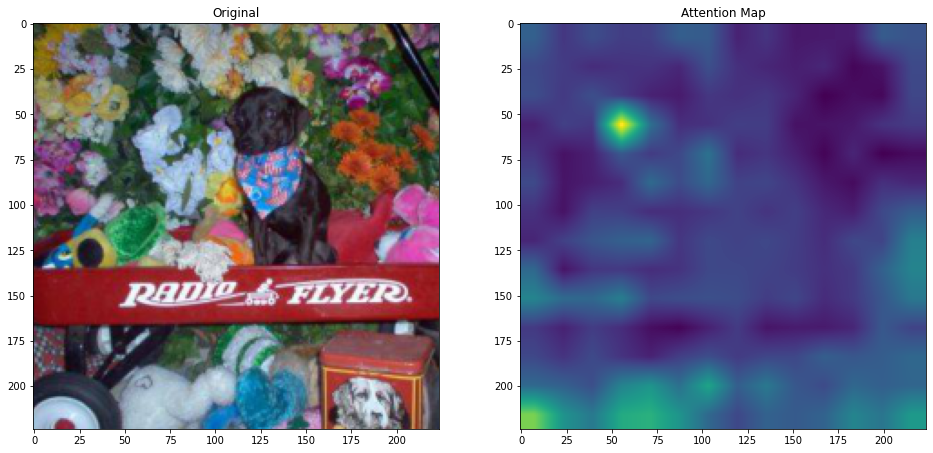

In [51]:
im = to_PIL(img_transformed)
model = model.cpu()
model.eval()

logits, inter_logits, att_mat, new_att_mat = model(img_transformed.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]


grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(mask)

In [53]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) # / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

In [54]:
vis = show_cam_on_image(im, new_mask)
vis =  np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

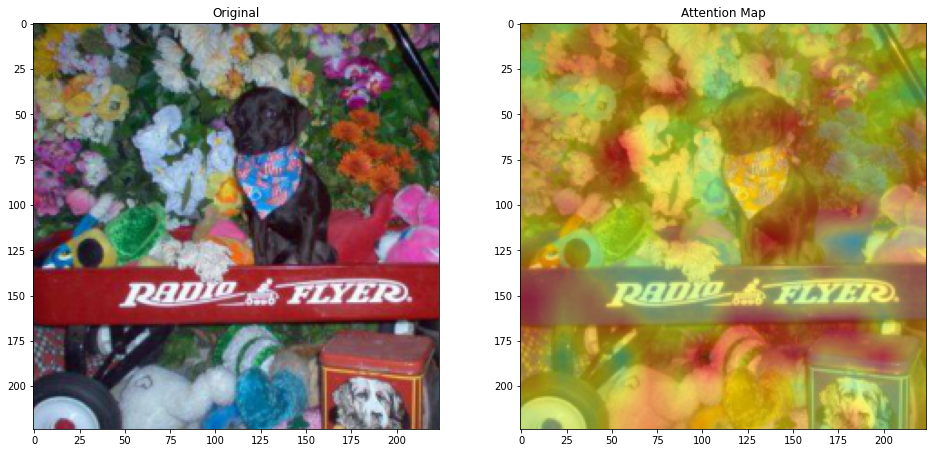

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(vis)

In [192]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [94]:
subset = list(range(0, 1000, 1))
test_set = torch.utils.data.Subset(test_data, subset)

In [95]:
test_loader = DataLoader(dataset = test_set, batch_size=32, shuffle=True)

In [78]:
class CausalMetric():

    def __init__(self, model, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.
        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn
        self.sm = torch.nn.Softmax(dim=-1)
        
    def single_run(self, img_tensor, label, explanation):
        r"""Run metric on one image-saliency pair.
        Args:
            img_tensor (Tensor): normalized image tensor.
            explanation (np.ndarray): saliency map.
            verbose (int): in [0, 1, 2].
                0 - return list of scores.
                1 - also plot final step.
                2 - also plot every step and print 2 top classes.
            save_to (str): directory to save every step plots to.
        Return:
            scores (nd.array): Array containing scores at every step.
        """
        n_steps = (HW + self.step - 1) // self.step

        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
            start = img_tensor.clone()
            finish = self.substrate_fn(img_tensor)
            finish = finish.cpu().numpy()
            
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
            start = self.substrate_fn(img_tensor).cuda()
            finish = img_tensor.clone()
            finish = finish.cpu().numpy()
            
        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency
        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        for i in range(n_steps+1):
            pred, _, _ , _ = self.model(start.unsqueeze(0))
            scores[i] = self.sm(pred)[0, label]
            
            if i < n_steps:
                start = start.cpu().numpy()
                coords = salient_order[:, self.step * i:self.step * (i + 1)]
                start.reshape(1, 3, HW)[0, :, coords] = finish.reshape(1, 3, HW)[0, :, coords]
                start = torch.from_numpy(start).cuda()
                
        return scores

In [79]:
model = model.cuda()
model.eval()
scores = {'del': [], 'ins': []}
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)
insertion = CausalMetric(model, 'ins', 224, substrate_fn=torch.zeros_like)
HW = 224 * 224

In [80]:
with torch.no_grad():
    for step, batch in enumerate(tqdm(test_loader)):
        print("step:{}".format(step))
        x, y = batch
        for image,label in zip(x, y):
            image = image.cuda()
            label = label.numpy()
            logits, _,  _, new_att_mat = model(image.unsqueeze(0))

            new_att_mat = new_att_mat.squeeze(0)
            avg_new_att_mat = torch.mean(new_att_mat, dim = 0)
            new_mask = avg_new_att_mat.reshape(grid_size, grid_size).cpu().detach().numpy()
            new_mask = cv2.resize(new_mask / new_mask.max(), im.size)[..., np.newaxis]

            del_score = deletion.single_run(image, label, new_mask)
            print("del_score:{}".format(del_score.mean()))
            scores['del'].append(del_score.mean())

            ins_score = insertion.single_run(image, label, new_mask)
            print("ins_score:{}".format(ins_score.mean()))
            scores['ins'].append(ins_score.mean())

  0%|                                                                                                                                                                                                                                                               | 0/32 [00:00<?, ?it/s]

step:0
del_score:0.4579982996814781
ins_score:0.6539948950211207
del_score:0.5981245756149292
ins_score:0.9734452851613362
del_score:0.6293278929260042
ins_score:0.8909479138586256
del_score:0.2920198658895161
ins_score:0.8362434105078379
del_score:0.4533826448933946
ins_score:0.6146387418462999
del_score:0.4136003147231208
ins_score:0.9541906169056893
del_score:0.6563976748453246
ins_score:0.9581564062171513
del_score:0.7085334673192766
ins_score:0.7854757623374462
del_score:0.7300443973143895
ins_score:0.9784830436441634
del_score:0.6183250804079904
ins_score:0.927306244822426
del_score:0.7472976891862022
ins_score:0.9789230838749143
del_score:0.6297236554490195
ins_score:0.9414180088705487
del_score:0.5692858277923531
ins_score:0.9122164562675688
del_score:0.5773562676376767
ins_score:0.9491510725021363
del_score:0.6184491237170167
ins_score:0.9160034696261088
del_score:0.6091172889206145
ins_score:0.9315851394997703
del_score:0.500367257354988
ins_score:0.9670994295676549
del_score

  3%|███████▋                                                                                                                                                                                                                                               | 1/32 [01:16<39:35, 76.61s/it]

ins_score:0.8839699808425373
step:1
del_score:0.510415915735066
ins_score:0.9385905133353339
del_score:0.519826773972147
ins_score:0.8431306922766897
del_score:0.6028542850911617
ins_score:0.6228077857527468
del_score:0.6240526404976845
ins_score:0.929946271247334
del_score:0.5133963233563635
ins_score:0.9570560366577572
del_score:0.6436038034492069
ins_score:0.9604788445101844
del_score:0.6148256469517946
ins_score:0.9530541218651666
del_score:0.7393693695465724
ins_score:0.8798527218898138
del_score:0.5271411631173558
ins_score:0.829499938438336
del_score:0.6302033929692374
ins_score:0.8715227339665095
del_score:0.31885889599306716
ins_score:0.9690720952219434
del_score:0.547383688920074
ins_score:0.965686660806338
del_score:0.7123244438568751
ins_score:0.9543782411019007
del_score:0.849070393509335
ins_score:0.8884423495994673
del_score:0.671783843719297
ins_score:0.9881690793567234
del_score:0.5176143864790599
ins_score:0.6221376034782993
del_score:0.6546157755123244
ins_score:0.89

  6%|███████████████▍                                                                                                                                                                                                                                       | 2/32 [02:33<38:26, 76.89s/it]

ins_score:0.9468997190395991
step:2
del_score:0.6778253146012624
ins_score:0.7828268214729097
del_score:0.5832056519058015
ins_score:0.9397546611891853
del_score:0.608980219827758
ins_score:0.8437197024830514
del_score:0.6859059639440642
ins_score:0.8680877552429835
del_score:0.5483286801973979
ins_score:0.9710805341932509
del_score:0.5541405459741752
ins_score:0.9695003987020916
del_score:0.5316684257777201
ins_score:0.975467063387235
del_score:0.6589863388902611
ins_score:0.927611759768592
del_score:0.6747329163551331
ins_score:0.9646762992276086
del_score:0.37931960287193456
ins_score:0.9566387024852965
del_score:0.6644040777451462
ins_score:0.9125245810879601
del_score:0.3995675386157301
ins_score:0.9506445409854253
del_score:0.7030041022433176
ins_score:0.8575242096185685
del_score:0.5121987645990319
ins_score:0.8603962157169978
del_score:0.596681977113088
ins_score:0.9720202691687478
del_score:0.576704640785853
ins_score:0.6773315981692738
del_score:0.6173742450815108
ins_score:0

  9%|███████████████████████▏                                                                                                                                                                                                                               | 3/32 [03:50<37:12, 76.99s/it]

ins_score:0.8022460486160384
step:3
del_score:0.5605343891349104
ins_score:0.9560192967454593
del_score:0.47215840361184547
ins_score:0.7571124486749371
del_score:0.8052377155754301
ins_score:0.9281687739160326
del_score:0.6390641122476922
ins_score:0.9429348134001097
del_score:0.7557041850354936
ins_score:0.9711461122830709
del_score:0.530018299486902
ins_score:0.9400058666865031
del_score:0.8991906238926781
ins_score:0.9807276107205285
del_score:0.26106204140207007
ins_score:0.907027262457543
del_score:0.6791851293378406
ins_score:0.8676958490908145
del_score:0.5642551171365712
ins_score:0.9536562140782674
del_score:0.3265696476875908
ins_score:0.6930201083421708
del_score:0.5607296359042326
ins_score:0.9269476337896453
del_score:0.6006172355678346
ins_score:0.9298099502921104
del_score:0.707464578722914
ins_score:0.9895291344324748
del_score:0.5487590419252714
ins_score:0.6321213535798921
del_score:0.6353500496678882
ins_score:0.9400796247853174
del_score:0.6914314652482668
ins_scor

 12%|██████████████████████████████▉                                                                                                                                                                                                                        | 4/32 [05:05<35:34, 76.24s/it]

ins_score:0.8948522610134548
step:4
del_score:0.81254119252993
ins_score:0.9330933756960763
del_score:0.4569967185209195
ins_score:0.8401836285822921
del_score:0.5214441286358569
ins_score:0.9872491584883796
del_score:0.5197659194303883
ins_score:0.6833872947158913
del_score:0.7528566584653325
ins_score:0.8602056918541591
del_score:0.4930311811053091
ins_score:0.960844870602919
del_score:0.4656301705622011
ins_score:0.9814121447669135
del_score:0.5030674755242136
ins_score:0.6188164138793946
del_score:0.8532003647751278
ins_score:0.9667654640807046
del_score:0.5565005210207569
ins_score:0.31509209505799746
del_score:0.5517290847169029
ins_score:0.6732290915648143
del_score:0.6474745210674074
ins_score:0.9340608632730113
del_score:0.4194800310768187
ins_score:0.9171667391724057
del_score:0.5513075058658917
ins_score:0.8843694652451409
del_score:0.6954098902808296
ins_score:0.936719362868203
del_score:0.6148548787501124
ins_score:0.9495084073808459
del_score:0.4400976617468728
ins_score:

 16%|██████████████████████████████████████▌                                                                                                                                                                                                                | 5/32 [06:21<34:16, 76.18s/it]

ins_score:0.6914202819930183
step:5
del_score:0.4788344059470627
ins_score:0.6755061660458644
del_score:0.7601069957680172
ins_score:0.9489325451850891
del_score:0.44360063360797036
ins_score:0.45751276697549553
del_score:0.6580669372611576
ins_score:0.9877950294812521
del_score:0.5177229780041509
ins_score:0.9685340358813603
del_score:0.6751634888433747
ins_score:0.9379774493641323
del_score:0.6096707607971298
ins_score:0.902793401810858
del_score:0.5861561427182621
ins_score:0.9380129967133204
del_score:0.6404983460240894
ins_score:0.9313853583070967
del_score:0.6512649571730031
ins_score:0.9711809579531352
del_score:0.5342821655670802
ins_score:0.9637558131416639
del_score:0.7618828766875797
ins_score:0.9581117195553249
del_score:0.6513415411528614
ins_score:0.9316987465487586
del_score:0.6286373406979773
ins_score:0.9241403716140323
del_score:0.5800924744870928
ins_score:0.7957783919903967
del_score:0.6519536620378494
ins_score:0.9695536218749152
del_score:0.516172504507833
ins_sco

 19%|██████████████████████████████████████████████▎                                                                                                                                                                                                        | 6/32 [07:37<32:50, 75.80s/it]

ins_score:0.9744938402043448
step:6
del_score:0.4350996811853515
ins_score:0.944438938498497
del_score:0.7445855747328864
ins_score:0.9523624360230234
del_score:0.5379714803563224
ins_score:0.4514731113115946
del_score:0.6793570703930325
ins_score:0.927277556127972
del_score:0.7709424857960807
ins_score:0.8626717279354731
del_score:0.5862617025110457
ins_score:0.8661272715528806
del_score:0.6340294290251202
ins_score:0.8737943506903119
del_score:0.7130513911777072
ins_score:0.9218214793337716
del_score:0.7554520273415579
ins_score:0.9596474325656891
del_score:0.6567583239740795
ins_score:0.9204790272315343
del_score:0.5995988292164273
ins_score:0.9807992956373427
del_score:0.5480947342846129
ins_score:0.7530347395688295
del_score:0.769474967122078
ins_score:0.9665411772992876
del_score:0.5645131772756576
ins_score:0.9090254075618254
del_score:0.6434807237154908
ins_score:0.9863960862159729
del_score:0.4625275543828805
ins_score:0.9337533440854814
del_score:0.6371852578512497
ins_score:

 22%|██████████████████████████████████████████████████████                                                                                                                                                                                                 | 7/32 [08:51<31:23, 75.36s/it]

ins_score:0.3142153736990359
step:7
del_score:0.523945697893699
ins_score:0.971658566262987
del_score:0.7126573766105705
ins_score:0.917999583515856
del_score:0.6159359387887848
ins_score:0.7266009479223026
del_score:0.7120597779750824
ins_score:0.8363800697194206
del_score:0.4210452634634243
ins_score:0.9787566441297532
del_score:0.46656888363262017
ins_score:0.9148005482885573
del_score:0.6070749538474612
ins_score:0.9706999440325631
del_score:0.7061371572150125
ins_score:0.9052112929688559
del_score:0.4671808639168739
ins_score:0.9294708993037542
del_score:0.49771234571312867
ins_score:0.8214556227789985
del_score:0.631672490818633
ins_score:0.7901736675368415
del_score:0.5630075642466545
ins_score:0.9486611693435245
del_score:0.5760894369747903
ins_score:0.8381606596418553
del_score:0.7945875059233771
ins_score:0.9388066547446781
del_score:0.6564231909977065
ins_score:0.9908081322246127
del_score:0.6415051798853609
ins_score:0.961878259976705
del_score:0.5192389514959521
ins_score:

 25%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 8/32 [10:05<30:01, 75.05s/it]

ins_score:0.9710364980167813
step:8
del_score:0.44067041733612616
ins_score:0.8893867022461361
del_score:0.8005043849680159
ins_score:0.88677553743124
del_score:0.6791830629110336
ins_score:0.947686459372441
del_score:0.7162241654925876
ins_score:0.8479626185364193
del_score:0.5885671290424135
ins_score:0.9775998326142629
del_score:0.6824443551898003
ins_score:0.7796135844290256
del_score:0.6132009782393774
ins_score:0.8204652266701062
del_score:0.7895823854870266
ins_score:0.8251863374643855
del_score:0.5267253051987952
ins_score:0.8092753894295958
del_score:0.5885893735455142
ins_score:0.8019752219319344
del_score:0.5935774179299672
ins_score:0.8128734030988481
del_score:0.5433372787965669
ins_score:0.9076808636056052
del_score:0.579652008795076
ins_score:0.9849095577663846
del_score:0.7646806515587701
ins_score:0.9467864608102374
del_score:0.6190161128011015
ins_score:0.8103289979696274
del_score:0.786179253856341
ins_score:0.9797821566793654
del_score:0.7022963395383623
ins_score:0

 28%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 9/32 [11:20<28:46, 75.07s/it]

ins_score:0.9203101969427533
step:9
del_score:0.679255569047398
ins_score:0.6624175836311447
del_score:0.8531717807716793
ins_score:0.9893555426597596
del_score:0.5059196396875713
ins_score:0.8522324186563491
del_score:0.5809835889604357
ins_score:0.829632492032316
del_score:0.6787361321349938
ins_score:0.8873987438943651
del_score:0.814022004240089
ins_score:0.5724928293418553
del_score:0.8061002025670475
ins_score:0.8536784448888567
del_score:0.7340600947207875
ins_score:0.9708627849155003
del_score:0.6858371368712849
ins_score:0.9076867425358958
del_score:0.5766166282031271
ins_score:0.8808038588364919
del_score:0.5716187127762371
ins_score:0.9930811929702759
del_score:0.6282670041587618
ins_score:0.5794399505191379
del_score:0.4804406803515222
ins_score:0.9610816832383474
del_score:0.7406090342667367
ins_score:0.9524741591347589
del_score:0.8591073956754472
ins_score:0.8356954549749692
del_score:0.6739077245112922
ins_score:0.9323949802584118
del_score:0.6582834175394641
ins_score:

 31%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 10/32 [12:34<27:20, 74.57s/it]

ins_score:0.9631016079584758
step:10
del_score:0.47911116276350285
ins_score:0.9345668246017562
del_score:0.7366876891089811
ins_score:0.886857872903347
del_score:0.5432457896818718
ins_score:0.9390686280197568
del_score:0.6594665569398138
ins_score:0.9787854517830743
del_score:0.8472500402397579
ins_score:0.9555549204349518
del_score:0.7016813036219941
ins_score:0.9486848739782969
del_score:0.5481775877997279
ins_score:0.949471160935031
del_score:0.5779192918539047
ins_score:0.9310081732273102
del_score:0.5443687207169003
ins_score:0.6492589491936895
del_score:0.702527201573054
ins_score:0.9908967241975997
del_score:0.5676410220066707
ins_score:0.8410950897799598
del_score:0.6290284694565667
ins_score:0.82924581223064
del_score:0.7076798231071896
ins_score:0.9747688890165753
del_score:0.7880407688352796
ins_score:0.8843649407558971
del_score:0.4270708090729184
ins_score:0.8518012654284636
del_score:0.5669891518519984
ins_score:0.900130959302187
del_score:0.6575224672423469
ins_score:0

 34%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 11/32 [13:48<25:59, 74.28s/it]

ins_score:0.5681258236699634
step:11
del_score:0.5974102398090892
ins_score:0.955926294459237
del_score:0.8744304167230924
ins_score:0.9590752167834176
del_score:0.5868800303008821
ins_score:0.9658368669615851
del_score:0.5727471057449778
ins_score:0.9579657359255684
del_score:0.6860992883973651
ins_score:0.8383588636252615
del_score:0.558141771753629
ins_score:0.9776523702012168
del_score:0.5880458141366641
ins_score:0.866747621662087
del_score:0.7164599078231387
ins_score:0.9616424959235721
del_score:0.7496648540099462
ins_score:0.9798979771137237
del_score:0.6127853737937079
ins_score:0.9140867837270101
del_score:0.4871317430668407
ins_score:0.8946594129668342
del_score:0.5869535051700142
ins_score:0.966132460700141
del_score:0.7167876505520608
ins_score:0.9649483078718185
del_score:0.43878384833534556
ins_score:0.9310697751740614
del_score:0.5205431279208925
ins_score:0.799337535334958
del_score:0.46551644111673035
ins_score:0.8418995005554623
del_score:0.6884848311874602
ins_score

 38%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 12/32 [15:05<25:05, 75.28s/it]

ins_score:0.9740886559751298
step:12
del_score:0.606057611240281
ins_score:0.9063983651664522
del_score:0.5658990089678102
ins_score:0.37079888138506145
del_score:0.5722650731934441
ins_score:0.7597358934415711
del_score:0.6155325940334134
ins_score:0.9827894140614404
del_score:0.5167698132495085
ins_score:0.6496829619776043
del_score:0.6673851541015837
ins_score:0.8728348427348667
del_score:0.6314831313159731
ins_score:0.8544094929761357
del_score:0.7330704897642135
ins_score:0.83105269783073
del_score:0.6339780329333411
ins_score:0.9822360975212521
del_score:0.5204521123402649
ins_score:0.8978180423047808
del_score:0.8490256730715434
ins_score:0.9697038718064626
del_score:0.5261453210479683
ins_score:0.9078718067540062
del_score:0.478582481013404
ins_score:0.6506299070848359
del_score:0.8054821003476779
ins_score:0.9272098664442698
del_score:0.8604644740952386
ins_score:0.9638986701435514
del_score:0.5000064140930772
ins_score:0.9875094159444173
del_score:0.797464959025383
ins_score:

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 13/32 [16:21<23:55, 75.56s/it]

ins_score:0.9607168242004183
step:13
del_score:0.718404683801863
ins_score:0.9595995015568204
del_score:0.6555529425210423
ins_score:0.3888408905433284
del_score:0.47790039906899134
ins_score:0.8023608622948328
del_score:0.6168140255080329
ins_score:0.7439631937609779
del_score:0.5798209975328711
ins_score:0.854769675301181
del_score:0.6040818531645669
ins_score:0.9834258206685385
del_score:0.5680407936043209
ins_score:0.9355015865961711
del_score:0.7989505919814109
ins_score:0.9529182762569851
del_score:0.5272541034966707
ins_score:0.9559863257408142
del_score:0.6550914768709076
ins_score:0.7825587902135319
del_score:0.7861742185221778
ins_score:0.8903737203942405
del_score:0.754874707940552
ins_score:0.8158107001251644
del_score:0.6174727870855067
ins_score:0.9443070016304652
del_score:0.6431623282035192
ins_score:0.7187894504600101
del_score:0.6937377868096034
ins_score:0.9726114459170235
del_score:0.642200388610363
ins_score:0.9644196391105652
del_score:0.5752920768058134
ins_score

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 14/32 [17:36<22:37, 75.43s/it]

ins_score:0.9458444806602266
step:14
del_score:0.6437889504432678
ins_score:0.950812479323811
del_score:0.7056495947970285
ins_score:0.9463963433437877
del_score:0.6599157553248935
ins_score:0.9360668073097865
del_score:0.36355223540837567
ins_score:0.9333221823887693
del_score:0.6506546489728822
ins_score:0.8416565940115187
del_score:0.6915864208009508
ins_score:0.8850589642425378
del_score:0.5908420133590698
ins_score:0.956027583943473
del_score:0.6168539498746395
ins_score:0.874672523604499
del_score:0.6010549116631348
ins_score:0.9679590309990777
del_score:0.7857182675600052
ins_score:0.7766961167918311
del_score:0.48093234583735467
ins_score:0.9757078602578905
del_score:0.6696677164402273
ins_score:0.9517380311754015
del_score:0.5524062386155129
ins_score:0.8497558585802714
del_score:0.6449751020057334
ins_score:0.9540395777755314
del_score:0.43906705825693076
ins_score:0.8738240900904768
del_score:0.8066351801156998
ins_score:0.9738341557979584
del_score:0.7487295060025321
ins_sc

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 15/32 [18:51<21:15, 75.05s/it]

ins_score:0.8713739053408305
step:15
del_score:0.4508465884418951
ins_score:0.9460883578161399
del_score:0.7599808350867695
ins_score:0.9323865867985619
del_score:0.41173392035894923
ins_score:0.9162164555655585
del_score:0.8116912900408109
ins_score:0.9507563114828533
del_score:0.5848542116582394
ins_score:0.8484324328808321
del_score:0.5456559848123127
ins_score:0.9450258730517493
del_score:0.6211305575486686
ins_score:0.9129269422818389
del_score:0.810199170841111
ins_score:0.9730079250203238
del_score:0.6244884071747462
ins_score:0.9002083853880565
del_score:0.6178466646124919
ins_score:0.993278919590844
del_score:0.5904843742483192
ins_score:0.9675717516740163
del_score:0.8954360699653625
ins_score:0.8428083816170693
del_score:0.7008627141846551
ins_score:0.9380686996711625
del_score:0.700487124522527
ins_score:0.963789398405287
del_score:0.6907266688015726
ins_score:0.964627689520518
del_score:0.4450695994537738
ins_score:0.9383207068799271
del_score:0.5993315975947513
ins_score:

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 16/32 [20:08<20:11, 75.69s/it]

ins_score:0.778306385576725
step:16
del_score:0.5840175181627274
ins_score:0.7922917293922769
del_score:0.8356973324219386
ins_score:0.9671907212999132
del_score:0.5240498518695434
ins_score:0.7996853533221616
del_score:0.6472818197806677
ins_score:0.5924613076117303
del_score:0.6562341778145896
ins_score:0.9797324050797357
del_score:0.7021407647927602
ins_score:0.9276414175331592
del_score:0.7336163642671373
ins_score:0.9836140036582947
del_score:0.7440565712584389
ins_score:0.9087467702892091
del_score:0.5589559254784965
ins_score:0.2584656410312487
del_score:0.6287965107626385
ins_score:0.6654656179745992
del_score:0.6955980950593948
ins_score:0.9674811735418107
del_score:0.48176000564462607
ins_score:0.7536049215661155
del_score:0.7905617910292414
ins_score:0.8832009400924047
del_score:0.7669105704625447
ins_score:0.9064376131362385
del_score:0.6839988428685401
ins_score:0.9448673416508568
del_score:0.7380622581640879
ins_score:0.9629344862037235
del_score:0.5941051635311709
ins_sc

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 17/32 [21:25<19:00, 76.02s/it]

ins_score:0.8606175071332189
step:17
del_score:0.5349737266037199
ins_score:0.8816846890250841
del_score:0.7503484804100461
ins_score:0.9658447144428889
del_score:0.640211958868636
ins_score:0.8867115333345201
del_score:0.6553794813818402
ins_score:0.9410847116178936
del_score:0.687216171556049
ins_score:0.9162210980388853
del_score:0.5970088109705183
ins_score:0.9492681782444318
del_score:0.4711524849798944
ins_score:0.9183793516953787
del_score:0.719695024225447
ins_score:0.8624867169062297
del_score:0.809900942047437
ins_score:0.9618766677379608
del_score:0.48556929145422245
ins_score:0.961293742524253
del_score:0.662300220463011
ins_score:0.8884098139405251
del_score:0.4781845044054919
ins_score:0.8918973061773512
del_score:0.535975127518177
ins_score:0.41356455013155935
del_score:0.639211088327898
ins_score:0.9755109928713904
del_score:0.6253759063614739
ins_score:0.9703637847635481
del_score:0.6264486912224028
ins_score:0.9826916337013245
del_score:0.6630243392288685
ins_score:0.

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 18/32 [22:41<17:44, 76.03s/it]

ins_score:0.8273152936829461
step:18
del_score:0.6186120474669669
ins_score:0.9516214520401425
del_score:0.5391493532392714
ins_score:0.9546049069075121
del_score:0.8319629951318105
ins_score:0.9844988152715894
del_score:0.6283385503126515
ins_score:0.981683017677731
del_score:0.6223067801528507
ins_score:0.8302139827609062
del_score:0.6785055731899209
ins_score:0.9097911552919282
del_score:0.6612339172098372
ins_score:0.9307563327418433
del_score:0.7617852661841445
ins_score:0.5875528011719385
del_score:0.608311938163307
ins_score:0.9136475019984776
del_score:0.5026563328504562
ins_score:0.9092834840218226
del_score:0.6793341227372487
ins_score:0.8499368777539995
del_score:0.6219788458446661
ins_score:0.7800457176897261
del_score:0.6154797998401854
ins_score:0.9720539320177503
del_score:0.4880782571766112
ins_score:0.5038564279178779
del_score:0.6445377171701855
ins_score:0.9696503583590189
del_score:0.8892700485057301
ins_score:0.8416544868217575
del_score:0.6213403770989842
ins_scor

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 19/32 [23:57<16:30, 76.17s/it]

ins_score:0.8271806382801797
step:19
del_score:0.7449775639507505
ins_score:0.9354546816481484
del_score:0.43051005530688496
ins_score:0.9612306698163351
del_score:0.5950647312568293
ins_score:0.8804754153887431
del_score:0.3291826359223988
ins_score:0.9161888939225011
del_score:0.5194340452593234
ins_score:0.9250977927032444
del_score:0.6116206108861499
ins_score:0.9675934297508664
del_score:0.5704966286652619
ins_score:0.9344393757979075
del_score:0.45616228312253954
ins_score:0.6633505386445258
del_score:0.5202975886522068
ins_score:0.9405715028444926
del_score:0.7450474559598499
ins_score:0.7074848228693008
del_score:0.6721954229142931
ins_score:0.9319067002005047
del_score:0.4364169735958179
ins_score:0.8844745826721191
del_score:0.6849453572928905
ins_score:0.8632499156064457
del_score:0.5814572873380449
ins_score:0.9175507518980238
del_score:0.5217105887333552
ins_score:0.9769059085845947
del_score:0.44044019127885503
ins_score:0.919191595448388
del_score:0.641226488550504
ins_s

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 20/32 [25:15<15:20, 76.72s/it]

ins_score:0.9811870829264323
step:20
del_score:0.7954623648524284
ins_score:0.9249994383586777
del_score:0.6292750027858549
ins_score:0.8228627075254917
del_score:0.540889471438196
ins_score:0.9157833009295994
del_score:0.661343546377288
ins_score:0.9294854603707791
del_score:0.532557142989503
ins_score:0.984414033624861
del_score:0.6577252798444695
ins_score:0.9522520249419743
del_score:0.682701059712304
ins_score:0.9125252972046535
del_score:0.5413140683041678
ins_score:0.8012029269006518
del_score:0.7171302347050773
ins_score:0.9808888619475894
del_score:0.7760253250309163
ins_score:0.9329334913359748
del_score:0.47979695642987885
ins_score:0.9549250759349929
del_score:0.7948164574305217
ins_score:0.9561565714743402
del_score:0.5428758506228526
ins_score:0.9655343039830526
del_score:0.5737623589071963
ins_score:0.7331563047568004
del_score:0.8089500518639883
ins_score:0.9283044230275684
del_score:0.8362160317765341
ins_score:0.47120616684357325
del_score:0.8634537624650531
ins_score

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 21/32 [26:34<14:10, 77.31s/it]

ins_score:0.9034934947225782
step:21
del_score:0.7042415028810501
ins_score:0.9486295951406161
del_score:0.6331774233198828
ins_score:0.9359634604387813
del_score:0.7020859324932098
ins_score:0.9202008160617616
del_score:0.5318766378031836
ins_score:0.9427022859785292
del_score:0.5310917637083266
ins_score:0.9282231608198749
del_score:0.8658542514509625
ins_score:0.9007650854852465
del_score:0.6294399094581604
ins_score:0.6950857964158058
del_score:0.6075183563513888
ins_score:0.9752296975255013
del_score:0.7097314855787489
ins_score:0.927393845849567
del_score:0.647157262712717
ins_score:0.8362960681650373
del_score:0.7665033556355371
ins_score:0.9463782860835394
del_score:0.4889801628680693
ins_score:0.9777106963263618
del_score:0.5163764671153492
ins_score:0.9639720631308025
del_score:0.712347335351838
ins_score:0.8614604633756809
del_score:0.5891519131925371
ins_score:0.9800733317269219
del_score:0.8347762220435673
ins_score:0.7987367730670505
del_score:0.7784285646014744
ins_score

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 22/32 [27:50<12:49, 76.92s/it]

ins_score:0.9730906330876881
step:22
del_score:0.7831419206990136
ins_score:0.9404047058357132
del_score:0.787745781077279
ins_score:0.9549408466948404
del_score:0.5118467771551676
ins_score:0.8860917154409819
del_score:0.5578172865344418
ins_score:0.9780473154120976
del_score:0.7250502171284623
ins_score:0.8549574960933791
del_score:0.5759685645086898
ins_score:0.8789508861303329
del_score:0.6409175245794985
ins_score:0.9865285666783651
del_score:0.5642156042489741
ins_score:0.8193971970015101
del_score:0.563314809832308
ins_score:0.976525661415524
del_score:0.5532426906294293
ins_score:0.5749773469898436
del_score:0.6259681915574603
ins_score:0.9652930514017741
del_score:0.5667685512329141
ins_score:0.9623572626378801
del_score:0.527077260427177
ins_score:0.8481440167294608
del_score:0.49848038805855643
ins_score:0.8947123885816998
del_score:0.5411938105523586
ins_score:0.9487346034579807
del_score:0.5869291038148933
ins_score:0.896238553126653
del_score:0.6210873712433709
ins_score:

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 23/32 [29:07<11:33, 77.01s/it]

ins_score:0.9514800399541855
step:23
del_score:0.7001408095823394
ins_score:0.7014837702446514
del_score:0.549452759789096
ins_score:0.9629919831620323
del_score:0.48521868424697057
ins_score:0.9331653328736623
del_score:0.7269112477699916
ins_score:0.9664979502889846
del_score:0.4852984940488305
ins_score:0.9361392062240177
del_score:0.5443760691086451
ins_score:0.9300309029552671
del_score:0.49897525103555784
ins_score:0.3791534067524804
del_score:0.5770958197447988
ins_score:0.9753025548656782
del_score:0.6377293598983023
ins_score:0.9082175189173883
del_score:0.4910424697274963
ins_score:0.5963700200782882
del_score:0.4130096420687106
ins_score:0.9158922340969244
del_score:0.5768732828729682
ins_score:0.9452943996588389
del_score:0.6547680737574896
ins_score:0.9628748010264503
del_score:0.6911112486653858
ins_score:0.947920696205563
del_score:0.7162051686396201
ins_score:0.9583823071585761
del_score:0.5202477503071229
ins_score:0.9030956104066636
del_score:0.6122096323304707
ins_sc

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 24/32 [30:23<10:13, 76.68s/it]

ins_score:0.8885277341968484
step:24
del_score:0.655277100569672
ins_score:0.9396991623772515
del_score:0.7467937803268433
ins_score:0.9262892793657052
del_score:0.5924056163099077
ins_score:0.7964876183205181
del_score:0.5313166271025935
ins_score:0.8770464361541801
del_score:0.5666707080933783
ins_score:0.8800403707060549
del_score:0.47420545770476263
ins_score:0.8633248854345745
del_score:0.7064851419462098
ins_score:0.9575224828720093
del_score:0.2901649657036695
ins_score:0.9577839642100864
del_score:0.5925052775939306
ins_score:0.9382884734206729
del_score:0.7498882097750902
ins_score:0.5775611065131508
del_score:0.6534690570500162
ins_score:0.8137192894683943
del_score:0.48638562275717656
ins_score:0.9625288319587707
del_score:0.8027576749192343
ins_score:0.7530809424486425
del_score:0.7431413027313021
ins_score:0.8203916294376056
del_score:0.7644893354177476
ins_score:0.8499890316194958
del_score:0.580133602089352
ins_score:0.9519016946686639
del_score:0.4599889666835467
ins_sc

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 25/32 [31:39<08:55, 76.57s/it]

ins_score:0.9153630592425664
step:25
del_score:0.53134372651577
ins_score:0.7543018680148654
del_score:0.5989056943522559
ins_score:0.8888238256507449
del_score:0.7346063758267297
ins_score:0.9783741674820582
del_score:0.5986131790777047
ins_score:0.9646305851803886
del_score:0.5787436263263226
ins_score:0.9686018053690593
del_score:0.5856303788349032
ins_score:0.910015945467684
del_score:0.5864957029951944
ins_score:0.7287865711417463
del_score:0.6002518257498741
ins_score:0.9579166558012366
del_score:0.7388045554028617
ins_score:0.8365216095248859
del_score:0.36321728084650307
ins_score:0.5177160878976186
del_score:0.716040894985199
ins_score:0.9519835105869505
del_score:0.6794069779581494
ins_score:0.9322717844777637
del_score:0.5274596059322357
ins_score:0.9675630661514071
del_score:0.5599380214181211
ins_score:0.8697951724214686
del_score:0.5001194037910964
ins_score:0.9402932193544176
del_score:0.7014396478732426
ins_score:0.909000902639495
del_score:0.8411685848236083
ins_score:

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 26/32 [32:57<07:40, 76.81s/it]

ins_score:0.93505350695716
step:26
del_score:0.5862748483320077
ins_score:0.9857248134083219
del_score:0.3133959469799366
ins_score:0.9292658265431722
del_score:0.5596125515302023
ins_score:0.6810009995102883
del_score:0.5965928510824839
ins_score:0.8279566105869082
del_score:0.8084940263960096
ins_score:0.8828010056416193
del_score:0.7156552053160138
ins_score:0.8692438296477
del_score:0.6905408181250096
ins_score:0.8369690312714212
del_score:0.7465690149863561
ins_score:0.8052211834159162
del_score:0.7238880161444347
ins_score:0.9747308368153043
del_score:0.5598392671098312
ins_score:0.7357190897729662
del_score:0.6563968139224582
ins_score:0.972440608077579
del_score:0.5356310771902403
ins_score:0.9377919856707255
del_score:0.4506321978237894
ins_score:0.9635549546612634
del_score:0.5739758181737529
ins_score:0.9611215520898501
del_score:0.8015372514724731
ins_score:0.941004700726933
del_score:0.4518444203388774
ins_score:0.8666160248054399
del_score:0.6168421910206476
ins_score:0.8

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 27/32 [34:13<06:22, 76.54s/it]

ins_score:0.9097050554222531
step:27
del_score:0.8265394804212782
ins_score:0.8973082377761602
del_score:0.42216434634808037
ins_score:0.9276799560917748
del_score:0.5300213724623124
ins_score:0.9361968812677596
del_score:0.5368675142526627
ins_score:0.5839375355922514
del_score:0.6218117861615287
ins_score:0.9366477473576864
del_score:0.7283864684899648
ins_score:0.9249076633403699
del_score:0.8092567290696833
ins_score:0.9804010558128357
del_score:0.6624678526322046
ins_score:0.960595269203186
del_score:0.6979882912503348
ins_score:0.6188380828499794
del_score:0.5336469876435068
ins_score:0.8840288299322129
del_score:0.6995475410752826
ins_score:0.8442071897122595
del_score:0.5335622022507919
ins_score:0.7431689734591378
del_score:0.717208926876386
ins_score:0.92643959985839
del_score:0.3672647705425819
ins_score:0.6210339495084352
del_score:0.5440452097853025
ins_score:0.9377772510051727
del_score:0.5888856422901153
ins_score:0.7589730107121997
del_score:0.6283909253279368
ins_score

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 28/32 [35:28<05:04, 76.14s/it]

ins_score:0.8055817735691865
step:28
del_score:0.6635164686375195
ins_score:0.9924053904745314
del_score:0.5093508765267001
ins_score:0.9582096760802798
del_score:0.6608584259947141
ins_score:0.9233159160200093
del_score:0.5072322744296657
ins_score:0.9757656641801198
del_score:0.6173305457168156
ins_score:0.9105234305726158
del_score:0.6031056838234266
ins_score:0.7868045471608639
del_score:0.6014157583730089
ins_score:0.9731303742196825
del_score:0.6184613467587365
ins_score:0.9027268234888712
del_score:0.6471444657444954
ins_score:0.9899063380559285
del_score:0.6589717227551672
ins_score:0.9515317984918753
del_score:0.6014351300398508
ins_score:0.5191076694097784
del_score:0.6275461432006624
ins_score:0.7257055085897446
del_score:0.7382941893074247
ins_score:0.9654112521476216
del_score:0.7509001808199618
ins_score:0.9690605264239841
del_score:0.6618694413287772
ins_score:0.8025935515243974
del_score:0.5326135824124019
ins_score:0.8697849810785717
del_score:0.7419610565900803
ins_sc

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 29/32 [36:45<03:49, 76.59s/it]

ins_score:0.20998171770945193
step:29
del_score:0.529902076340384
ins_score:0.9121654319763184
del_score:0.8289942075146569
ins_score:0.9694426845179663
del_score:0.7378766304916806
ins_score:0.9312891800204913
del_score:0.5259947016172939
ins_score:0.8046796107954449
del_score:0.693714804550012
ins_score:0.9245449937962823
del_score:0.6679232470856773
ins_score:0.8944084773957729
del_score:0.7067737392750051
ins_score:0.9636079062355889
del_score:0.5521661183734735
ins_score:0.9209732675552368
del_score:0.7535479861497879
ins_score:0.9575834974977705
del_score:0.5933295974797673
ins_score:0.8220990423609813
del_score:0.7294303556283315
ins_score:0.929518198106024
del_score:0.8280277892284923
ins_score:0.8777739576498668
del_score:0.6730643262134658
ins_score:0.9256867360737588
del_score:0.8941832382149166
ins_score:0.8845221667157279
del_score:0.5798502594398127
ins_score:0.9580101829104953
del_score:0.7236785548263126
ins_score:0.8751075163152483
del_score:0.7411460331910187
ins_scor

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 30/32 [38:02<02:33, 76.61s/it]

ins_score:0.8855979491935836
step:30
del_score:0.5974044540358914
ins_score:0.8718958301676645
del_score:0.7064409487280581
ins_score:0.9807292069329155
del_score:0.5497022364040216
ins_score:0.902480057477951
del_score:0.682280498445034
ins_score:0.9572031626436446
del_score:0.6841740824696091
ins_score:0.8962328743603495
del_score:0.4929083497491148
ins_score:0.665331279080775
del_score:0.7700631314516068
ins_score:0.34031449548072285
del_score:0.8508302322361204
ins_score:0.9922550927268134
del_score:0.5309421789977286
ins_score:0.7369157996111446
del_score:0.6926522520184517
ins_score:0.9818921269310845
del_score:0.8052938907013999
ins_score:0.9185376799106598
del_score:0.44274540749688945
ins_score:0.7409389127180395
del_score:0.804353067278862
ins_score:0.8978136973248587
del_score:0.6828387143876817
ins_score:0.9875860591729482
del_score:0.6132945640385151
ins_score:0.980344131257799
del_score:0.8079825652970208
ins_score:0.9805011902915107
del_score:0.5582443645762073
ins_score

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 31/32 [39:18<01:16, 76.48s/it]

ins_score:0.9423782774143749
step:31
del_score:0.550380062394672
ins_score:0.8647362010512087
del_score:0.6547325077321794
ins_score:0.9227742386526532
del_score:0.5010993026693662
ins_score:0.7715494843324026
del_score:0.7264388036396768
ins_score:0.9295851016044616
del_score:0.47886961117386817
ins_score:0.629874335800608
del_score:0.6586118961042828
ins_score:0.9060225096676084
del_score:0.7012962485684289
ins_score:0.9404695312182109
del_score:0.5729761072744926


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [39:37<00:00, 74.31s/it]

ins_score:0.8725665094123947


In [81]:
curDelection = sum(scores['del'])/len(scores['del'])
curInsertion = sum(scores['ins'])/len(scores['ins'])

print("current deletion score: {}".format(curDelection))
print("current insertion score: {}".format(curInsertion))

current deletion score: 0.6247624217237534
current insertion score: 0.8783636104430615
